In [76]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from scipy import stats
import sklearn
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn import metrics

random_seed = 2 # Set the random seed for all remaining random_state for determinism

## Load data

In [4]:
data_dir = "/Users/jameschen/Desktop/Cogs118B Intro to ML II/final_project/data"

train_mnist_path = os.path.join(data_dir, "train.csv")
# test_mnist_path = os.path.join(data_dir, "test.csv")
train_df = pd.read_csv(train_mnist_path)
# test_df = pd.read_csv(test_mnist_path)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
dtype: int64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

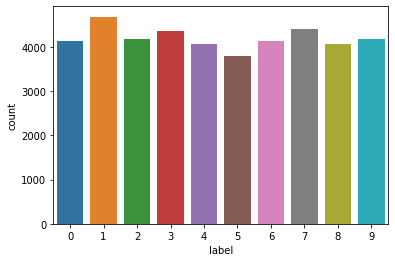

In [5]:
## early explore MNIST data
display(train_df)
display(train_df.groupby("label").size())
sns.countplot(train_df["label"])

In [15]:
# max value is 255 -> need normalization
train_df.iloc[:, 1:].max().max()

255

## Preprocess data

(1000, 785)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

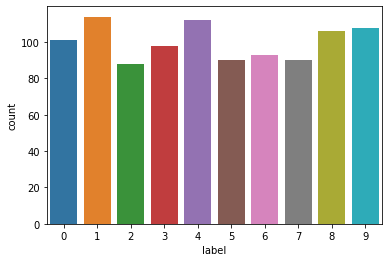

In [6]:
# Sampling 
train_df_s = train_df.sample(1000, replace=False, random_state=random_seed)
display(train_df_s.shape)
sns.countplot(train_df_s["label"]) # check if still balance

In [7]:
# extract and normalize features and labels
X_train = np.reshape(train_df_s.iloc[:, 1:].values / 255, (-1, 784))
Y_train = train_df_s["label"].values
# Y_train = to_categorical(Y_train_class, num_classes=10, dtype=int)   # one-hot encoding

print(X_train.shape, Y_train.shape)

(1000, 784) (1000,)


## Method

cluster alg + metric

Metric:   
SC: Silhouette Coefficient

### K-Means

In [32]:
# ## Self-implemented, slower than SKlearn
# def calcSqDistances(X, Kmus):
#     """
#     Vectorized squared dist between 2 matrices of points
#     return:
#         [N, D],[K, D] --> [N,K]
#     """ 
#     N, D = X.shape
#     K = len(Kmus)
    
#     X_copy = X.reshape(N,1,D)
#     Kmus_copy = Kmus.reshape(1,K,D)
#     sqdist = ((X_copy - Kmus_copy)**2).sum(axis=-1)
#     return sqdist

# def determineRnk(sqDmat):
#     """
#     Vectorized operations to determine the closest mu given sqdist matrix 
#     return:
#         A binary N-by-K responsibility matrix: [N,K]--> [N,K]
#     """ 
#     N,K = sqDmat.shape
#     R = np.zeros((N,K))
#     ind = np.argmin(sqDmat, axis=-1)
#     R[np.arange(N), ind] = 1
#     return R

# def recalcMus(X, Rnk):
#     """
#     Vectorized operations to Recalculate mus values from points in their cluster,
#     given the R is fixed
#     return:
#         new mus: [N,D],[N,K]--> [K,D]
#     """
#     N, D = X.shape
#     _, K = Rnk.shape
    
#     X_copy = X.reshape(N,1,D) # [N,K,D]
#     Rnk_copy = Rnk.reshape(N,K,1)
#     new_kmus = X_copy * Rnk_copy # take in responsibility
#     new_kmus = new_kmus.sum(axis=0) /Rnk.sum(axis=0)[:,None]  #[K,D]
#     return new_kmus

# def runKMeans(K, X):
#     # Determine and store data set information
#     N = np.shape(X)[0]
#     D = np.shape(X)[1]

#     # Allocate space for the K mu vectors
#     Kmus = np.zeros((K, D))

#     # Initialize cluster centers by randomly picking points from the data
#     rndinds = np.random.permutation(N)
#     Kmus = X[rndinds[:K]];

#     # Specify the maximum number of iterations to allow
#     maxiters = 1000;

#     for i in tqdm.trange(maxiters):
#         # sqDmat will be an N-by-K matrix with the n,k entry 
#         sqDmat = calcSqDistances(X, Kmus); # [N, D],[K, D] --> [N,K]

#         # R is the "responsibility"  N-by-K matrix of binary values 
#         # Specifically, the n,k entry is 1 if point n is closest to cluster k,
#         Rnk = determineRnk(sqDmat)

#         KmusOld = Kmus
# #         plotCurrent(X, Rnk, Kmus)
# #         plt.show()

#         # Recalculate mu values based on cluster assignments as per Bishop (9.4)
#         Kmus = recalcMus(X, Rnk)

#         # Check to see if the cluster centers have converged.  If so, break.
#         if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
#             break
#     return Rnk.argmax(axis=1)

In [109]:
def run_cluster_alg(X, cluster="kmeans", metric="SC", K_range=(10,), iteration=5):
    """
    Core alg to run each cluster and calculate metrix
    Arg:
        cluster_func: some cluster scheme
    """
    metric_for_K_list = []
    label_for_K_list = []
    for K in tqdm.tqdm(K_range):
        metric_iter_list = []
        label_iter_list = []
        for i in range(iteration): 
            # For each K and each iter, compute label and metrics
            if cluster == "kmeans":
                kmeans = KMeans(n_clusters=K).fit(X)
                Y_pred = kmeans.labels_
            elif cluster == "xxx":
                pass # TODO
            
            if metric == "SC":
                pred_metric = metrics.silhouette_score(X, Y_pred)
            elif metric == "consistency":
                pred_metric = 0 ## null value, decide later
                pass # TODO

            metric_iter_list.append(pred_metric)
            label_iter_list.append(Y_pred)
        
        if metric == "consistency":
            mode_label = stats.mode(label_iter_list).mode.astype(int).flatten()
            metric_iter_list = []
            for label in label_iter_list:
                fake_range_index = metrics.rand_score(mode_label, label)
                metric_iter_list.append(fake_range_index)
            metric_for_K_list.append(-np.var(metric_iter_list)) # max -var
            
            label_for_K_list.append(label_iter_list[np.argmax(metric_iter_list)])
        else:
            metric_for_K_list.append(np.mean(metric_iter_list))
            label_for_K_list.append(label_iter_list[np.argmax(metric_iter_list)])
            
    best_K_ind = np.argmax(metric_for_K_list)
    best_K = K_range[best_K_ind]
    best_metric = metric_for_K_list[best_K_ind]
    best_label = label_for_K_list[best_K_ind]
    return best_K, best_metric, best_label

In [89]:
a = [[1., 2., 3.],
           [0., 1., 3.],
           [0., 2., 1.]]
a 

[[1.0, 2.0, 3.0], [0.0, 1.0, 3.0], [0.0, 2.0, 1.0]]

In [94]:
stats.mode(a).mode.astype(int).flatten()

array([0, 2, 3])

In [96]:
mode_label = stats.mode(a).mode.astype(int).flatten()

label_iter_list= [[0,1,1], mode_label, mode_label]


metric_iter_list = []
for label in label_iter_list:
    fake_range_index = metrics.rand_score(mode_label, label)
    metric_iter_list.append(fake_range_index)
-np.var(metric_iter_list) # max -var

-0.024691358024691367

In [14]:
Y_pred = runKMeans(10, X_train)
Y_pred.shape

  2%|▏         | 18/1000 [00:01<00:59, 16.46it/s]


(1000,)

In [27]:
kmeans = KMeans(n_clusters=10).fit(X_train)
kmeans.labels_.shape

(1000,)

## Evaluation

In [110]:
K_range = [2,3,5,7,10,13,15]
K_pred, metric_pred, Y_pred = run_cluster_alg(X_train, cluster="kmeans", metric="SC", K_range=K_range, iteration=10)
print(K_pred, metric_pred)

100%|██████████| 7/7 [00:21<00:00,  3.06s/it]

2 0.1013903751211895


In [107]:
metrics.rand_score(Y_train, Y_pred), K_pred, metric_pred

(0.8518678678678678, 7, -4.738397496595655e-06)

In [20]:
metrics.rand_score(Y_train, kmeans.labels_)

0.882978978978979